Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель. Готовы приступить?

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

1. Restaurant_id — идентификационный номер ресторана / сети ресторанов;
2. City — город, в котором находится ресторан;
3. Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. Price Range — диапазон цен в ресторане;
7. Number of Reviews — количество отзывов о ресторане;
8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
9. URL_TA — URL страницы ресторана на TripAdvosor;
10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
# промаркируем тренировочный и тестовый сеты

df_train['mark'] = 1
df_test['mark'] = 0

# пропущенные значения для тестового сета заменим на 0
df_test['Rating'] = 0  

# объединим сеты для общей обработки данных
df = df_test.append(df_train, sort=False).reset_index(drop=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,mark,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [3]:
# проверим наименования столбцов и заменим их на более краткие
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'mark', 'Rating'],
      dtype='object')

Назначим наименования столбцов для своего удобства

In [4]:
df.columns = ['id','city','cuisine','ranking','price','num_rew',
             'reviews','url','id_ta','mark','rating']

Проверим столбцы на пропуски в данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
id         50000 non-null object
city       50000 non-null object
cuisine    38410 non-null object
ranking    50000 non-null float64
price      32639 non-null object
num_rew    46800 non-null float64
reviews    49998 non-null object
url        50000 non-null object
id_ta      50000 non-null object
mark       50000 non-null int64
rating     50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


В части столбцов есть пропуски. Суммарное количество строк 50000.

# Проверим столбцы отдельно.

# Restraunt_id

In [6]:
df.id.isna().value_counts()

False    50000
Name: id, dtype: int64

Пропусков нет, но тип данных не числовой. Преобразуем, удалив id_ и преобразовав в INT

In [7]:
df['id']=df.id.apply(lambda x: int(x[3:]))

In [8]:
# df.head()#проверим изменения в столбце

In [9]:
# проверим длинну, чтоб убедиться в отсутствии потери данных
len(df.id)


50000

# Проверим столбец City

In [10]:
df.city.isna().value_counts()

False    50000
Name: city, dtype: int64

Проверим правильность записи наименований городов

In [11]:
# df.city.value_counts()

In [12]:
df.city.describe()

count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

Согласно описанию солбца уникальных городов 31, Лондон наиболее часто упоминаемый

Создадим словарь, содержащий наименования городов в качестве ключей и порядковый номер, в качестве числового признака

In [13]:
A = list(df.city.value_counts().keys())
B = range(0, len(A))
dict_city = dict(zip(A, B))
dict_city

{'London': 0,
 'Paris': 1,
 'Madrid': 2,
 'Barcelona': 3,
 'Berlin': 4,
 'Milan': 5,
 'Rome': 6,
 'Prague': 7,
 'Lisbon': 8,
 'Vienna': 9,
 'Amsterdam': 10,
 'Brussels': 11,
 'Hamburg': 12,
 'Munich': 13,
 'Lyon': 14,
 'Stockholm': 15,
 'Budapest': 16,
 'Warsaw': 17,
 'Dublin': 18,
 'Copenhagen': 19,
 'Athens': 20,
 'Edinburgh': 21,
 'Zurich': 22,
 'Oporto': 23,
 'Geneva': 24,
 'Krakow': 25,
 'Oslo': 26,
 'Helsinki': 27,
 'Bratislava': 28,
 'Luxembourg': 29,
 'Ljubljana': 30}

Добавим в набор данных признак, основанный на порядковом номере города

In [14]:
df['City_ind'] = df['city'].replace(A, B)

Приведем отзывы к количесту упоминаний городов

In [15]:
A = list(df.city.value_counts().keys())
df_city = pd.DataFrame()
df_city['city'] = df['city']
df_city['ranking'] = df['ranking']
df_city = pd.DataFrame(df_city.groupby(['city']).max())
df_rank = df_city['ranking']

A = list(df_rank.keys())
B = list(df_rank)

df['city_rest'] = df['city'].replace(A, B)

df['std_rank'] = df['ranking']/df['city_rest']

df.head()
A

['Amsterdam',
 'Athens',
 'Barcelona',
 'Berlin',
 'Bratislava',
 'Brussels',
 'Budapest',
 'Copenhagen',
 'Dublin',
 'Edinburgh',
 'Geneva',
 'Hamburg',
 'Helsinki',
 'Krakow',
 'Lisbon',
 'Ljubljana',
 'London',
 'Luxembourg',
 'Lyon',
 'Madrid',
 'Milan',
 'Munich',
 'Oporto',
 'Oslo',
 'Paris',
 'Prague',
 'Rome',
 'Stockholm',
 'Vienna',
 'Warsaw',
 'Zurich']

На основании данных переписи населения можем составить дополнительный числовой признак по количеству населения.

Для этого созададим список с жителями, в соответствии с порядковым номером города

P.S. В baseline приведен список с население, который сводится со списком городов. В итоге в списке А города по алфавиту и население некорректно по ним распределяется. Здесь население указано в соответствии с фактической последовательностью городов при загрузке их в список

In [16]:

B = [869709, 664046, 5575000, 3769000, 424428, 174383, 1752000, 602481,
    1388000, 482005, 499480, 1899000, 631695, 769498, 504718, 342039,
    8982000, 613894, 513275, 6642000, 1352000, 1472000, 214349, 681067,
    2148000, 1309000, 2873000, 975904, 1897000, 1708000, 402762]
dict_popul = dict(zip(A,B))
df['population'] = df['city'].replace(A,B)
df.head()


,id,city,cuisine,ranking,price,num_rew,reviews,url,id_ta,mark,rating,City_ind,city_rest,std_rank,population
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,13986.0,0.926855,2148000
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,27,1141.0,0.092901,631695
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,21,1766.0,0.458664,482005
3,3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,16444.0,0.101496,8982000
4,4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,28,889.0,0.041620,424428


По аналогии с городами добавим числовые признаки стран. Не будем выдумывать и воспользуемся кодом из Baseline

Для понимания: присвоим новому столбцу строковые значения столбца city, потом заменим их, составим словарь с ключами-странами и значениями-индексами. Далее в новом столбце Country заменим наименования стран на числовые значения.

In [17]:
df['country'] = df.city
df['country'] = df['country'].replace('London', 'GreatBritain')
df['country'] = df['country'].replace('Paris', 'France')
df['country'] = df['country'].replace('Madrid', 'Spain')
df['country'] = df['country'].replace('Barcelona', 'Spain')
df['country'] = df['country'].replace('Berlin', 'Germany')
df['country'] = df['country'].replace('Milan', 'Italy')
df['country'] = df['country'].replace('Rome', 'Italy')
df['country'] = df['country'].replace('Prague', 'CzechRepublic')
df['country'] = df['country'].replace('Lisbon', 'Portugal')
df['country'] = df['country'].replace('Vienna', 'Austria')
df['country'] = df['country'].replace('Amsterdam', 'Netherlands')
df['country'] = df['country'].replace('Brussels', 'Belgium')
df['country'] = df['country'].replace('Hamburg', 'Germany')
df['country'] = df['country'].replace('Munich', 'Germany')
df['country'] = df['country'].replace('Lyon', 'France')
df['country'] = df['country'].replace('Stockholm', 'Sweden')
df['country'] = df['country'].replace('Budapest', 'Hungary')
df['country'] = df['country'].replace('Warsaw', 'Poland')
df['country'] = df['country'].replace('Dublin', 'Irland')
df['country'] = df['country'].replace('Copenhagen', 'Denmark')
df['country'] = df['country'].replace('Athens', 'Greece')
df['country'] = df['country'].replace('Edinburgh', 'Scotland')
df['country'] = df['country'].replace('Zurich', 'Switzeland')
df['country'] = df['country'].replace('Oporto', 'Portugal')
df['country'] = df['country'].replace('Geneva', 'Switzeland')
df['country'] = df['country'].replace('Krakow', 'Poland')
df['country'] = df['country'].replace('Oslo', 'Norway')
df['country'] = df['country'].replace('Helsinki', 'Finland')
df['country'] = df['country'].replace('Bratislava', 'Slovakia')
df['country'] = df['country'].replace('Luxembourg', 'Luxembourg')
df['country'] = df['country'].replace('Ljubljana', 'Slovenia')

A = list(df.country.value_counts().keys())
B = range(0, len(A))
dict_country = dict(zip(A, B))
# словарь со значениями стран


df['country_ind'] = df['country'].replace(A, B)

Добавим показатель турпотока в страны Европы. Возьмем статистические данные с открытых источников
https://knoema.ru/atlas/topics/%d0%a2%d1%83%d1%80%d0%b8%d0%b7%d0%bc/%d0%9a%d0%bb%d1%8e%d1%87%d0%b5%d0%b2%d1%8b%d0%b5-%d0%bf%d0%be%d0%ba%d0%b0%d0%b7%d0%b0%d1%82%d0%b5%d0%bb%d0%b8-%d1%82%d1%83%d1%80%d0%b8%d0%b7%d0%bc%d0%b0/%d0%a7%d0%b8%d1%81%d0%bb%d0%be-%d0%bf%d1%80%d0%b8%d0%b1%d1%8b%d1%82%d0%b8%d0%b9

In [18]:
df['flow'] = df.country
df['flow'] = df['flow'].replace('GreatBritain', 36316000)
df['flow'] = df['flow'].replace('France', 89322000)
df['flow'] = df['flow'].replace('Spain', 82773000)
df['flow'] = df['flow'].replace('Spain', 82773000)
df['flow'] = df['flow'].replace('Germany', 38881000)
df['flow'] = df['flow'].replace('Italy', 61567200)
df['flow'] = df['flow'].replace('Italy', 61567200)
df['flow'] = df['flow'].replace('CzechRepublic', 10611000)
df['flow'] = df['flow'].replace('Portugal', 16186000)
df['flow'] = df['flow'].replace('Austria', 30816000)
df['flow'] = df['flow'].replace('Netherlands', 18780000)
df['flow'] = df['flow'].replace('Belgium', 9119000)
df['flow'] = df['flow'].replace('Germany', 38881000 )
df['flow'] = df['flow'].replace('Germany', 38881000)
df['flow'] = df['flow'].replace('France', 89322000 )
df['flow'] = df['flow'].replace('Sweden', 7440000)
df['flow'] = df['flow'].replace('Hungary', 17552000)
df['flow'] = df['flow'].replace('Poland', 19622000)
df['flow'] = df['flow'].replace('Irland', 10926000)
df['flow'] = df['flow'].replace('Denmark', 12749000)
df['flow'] = df['flow'].replace('Greece', 30123000)
df['flow'] = df['flow'].replace('Scotland', 36316000 )
df['flow'] = df['flow'].replace('Switzeland', 10362000)
df['flow'] = df['flow'].replace('Portugal', 16186000 )
df['flow'] = df['flow'].replace('Switzeland', 10362000)
df['flow'] = df['flow'].replace('Poland', 19622000)
df['flow'] = df['flow'].replace('Norway', 5688000)
df['flow'] = df['flow'].replace('Finland', 3224000 )
df['flow'] = df['flow'].replace('Slovakia', 2256000)
df['flow'] = df['flow'].replace('Luxembourg', 1018000 )
df['flow'] = df['flow'].replace('Slovenia', 4425000 )





# Cuisine Style

Проверим столбец с кухнями

In [19]:
df['cuisine'].isna().value_counts()

False    38410
True     11590
Name: cuisine, dtype: int64

Посмотрим образец формы предоставления информации с строках

In [20]:
df['cuisine'][1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

Подсчитаем сколько различных кухонь в каждом ресторане, собрав их в списки и посчитав их длины

In [21]:
# сделаем копию данных без пропусков, чтоб можно было подсчитать 
# среднее количество кухонь для заполнения пропусков 
df_cus = df['cuisine'].fillna("'No info'")



In [22]:
df_cus = df_cus.apply(lambda x: x[1:-1])
df_cus = df_cus.apply(lambda x: x.strip("'''"))

In [23]:
df_cus = df_cus.apply(lambda x: x.split(','))

Пройдем циклом по столбцу, соберем всё в список и создадим новый признак по количеству представленных кухонь для каждого ресторана. Для пропущенных значений установим значение 1 (длина списка со значением 'No info'), предполагая, что ресторан не делает акцент на кухне, тем самым не предполагает специфику в своей работе 

In [24]:

cus_list = []
for i in df_cus:
    cus_list.append(len(i))
cus_list

np.mean(cus_list)

2.62532

In [25]:
df['cus_number'] = cus_list

Проверим, что ничего не потеряли

In [26]:
df['cus_number'].isna().value_counts()

False    50000
Name: cus_number, dtype: int64

Воспользуемся кодом из Baseline, чтоб составить признаки по присутствию кухонь в каждом ресторане.

In [27]:

df['cuisine'] = df['cuisine'].fillna('""No_info"')

new = pd.DataFrame(df.cuisine.dropna())
a = list(new.cuisine)
b = list()

def l(x):
    i = 0
    for g in x:
        f = x[i].split(',')
        v = 0
        for g in f:
            h = f[v][2:-1].replace("'", '')
            v = +1
            b.append(h)
        i += 1
        
l(a)

from collections import Counter

coun=Counter(b)
coun=dict(coun)
coun=pd.DataFrame({'count':coun}, columns=['count'])
a=coun['count'].mean()

b=list(coun.query('count > @a').index)
b

#оставляем только самые популярные кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in b:
    df[item] = df['cuisine'].apply(find_item)

df['cuisine'] = df['cuisine'].apply(lambda x: len(x))

# len(df['cuisine'])

# Ranking

Преобразуем значения в рейтинге в INT

In [28]:
df['ranking'].isna().value_counts()

False    50000
Name: ranking, dtype: int64

In [29]:
df['ranking'] = df['ranking'].apply(lambda x: int(x))

# Price

Смотрим пропуски в данных

In [30]:
df['price'].isna().value_counts()

False    32639
True     17361
Name: price, dtype: int64

Проверим формат данных и наличие пропусков.

In [31]:
df['price'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

Указанные диапазоны цен переведем в числовой формат. Пропуски заменим средней ценой

In [32]:
df['price'] = df['price'].replace('$',1)
df['price'] = df['price'].replace('$$ - $$$',2)
df['price'] = df['price'].replace('$$$$',3)

Пропуски заполним средним значением цены

In [33]:
price_mean = round(df['price'].mean(),2)

In [34]:
df['price'] = df['price'].fillna(price_mean)

In [35]:
df['price'].unique()

array([2.  , 3.  , 1.  , 1.82])

Проверим количество строк

In [36]:
df['price'].isna().value_counts()


False    50000
Name: price, dtype: int64

# Reviews

In [37]:
# df.head()

Проверим данные. Обратим внимание, что пропуски здесь отражены, как пустые квадратные скобки [[], []].

In [38]:
df['reviews'].unique()

array(['[[], []]',
       "[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",
       "[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]",
       ...,
       "[['Good by swedish standards', 'A hidden jewel in the middle of Västertorp...'], ['11/03/2016', '04/12/2008']]",
       "[['Underground restaurant', 'Oldest Restaurant in Warsaw'], ['07/11/2017', '06/18/2017']]",
       "[['Average', 'Nice an informal'], ['01/31/2016', '07/04/2012']]"],
      dtype=object)

In [39]:
df['reviews'] = df.reviews.replace('[[], []]', 'No_info')

Из отзывов выделим даты последних отзывов, чтоб соотнести их с нынешней датой, для определения давности последнего

In [40]:
df['last_rew'] = df['reviews']

df['last_rew']=df['last_rew'].str[-27:-17]

now = datetime.now()

#base['Last_rew'][base.Last_rew.str.contains("]")]=now
df['last_rew'][df.last_rew.str.contains("]")==True] = now
df['last_rew'] = df['last_rew'].fillna(now)

# приравниваем строки без даты к сегодня

df['last_rew'] = [pd.to_datetime(i) for i in df.last_rew]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
df['last_rew_date'] = abs(df['last_rew']-now)
df['last_rew_date'] = [i.total_seconds() for i in df.last_rew_date]
df['last_rew_date'] = df['last_rew_date']
df['last_rew_date'] = df['last_rew_date'].fillna(0)



# print('')
# print(len(df.last_rew_date))
print((df.last_rew_date[1]))

87913350.978773


# Number of reviews

In [42]:
df['num_rew'].isna().value_counts()

False    46800
True      3200
Name: num_rew, dtype: int64

Видим пропуски в данных. Пропущенные значения в количестве отзывов, но, фактически, имеющие таковые заменим на среднее значение

In [43]:
mean_rev = df['num_rew'].mean()
mean_rev

124.47119658119658

In [44]:
df['num_rew'] = df['num_rew'].fillna('No_info')

Сравним фактическое отсутвие информации с отсутвием/наличием отзывов в колонке reviews

In [45]:
df_rev = df[(df['num_rew'] == 'No_info') & (df['reviews'] == 'No_info')]
rev_index = list(df_rev.index)


In [46]:
index_list = []
for i in df_rev.index:
    index_list.append(i)

for i in index_list:
    df['num_rew'][i] = 0
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Отсутствующие значения заменим средним количеством отзывов

In [47]:
df['num_rew'] = df['num_rew'].replace('No_info',mean_rev)

In [48]:
type(np.array(df['num_rew']))

numpy.ndarray

In [49]:
df['num_rew'].isna().value_counts()

False    50000
Name: num_rew, dtype: int64

In [50]:
df['population'].isna().value_counts()

False    50000
Name: population, dtype: int64

Добавим признак соотношения населения к количеству отзывов

In [51]:
ratio_list = []
for i in range(0, len(df.num_rew)):
    ratio_list.append(df['num_rew'][i]/df['population'][i])



In [52]:
df['ratio_rev'] = ratio_list

# ID_TA

Иднетификатор с системе Trip Advisor. Переведем в INT

In [53]:
df['id_ta'] = df['id_ta'].str[1:]

In [54]:
for i in df.id_ta:
    i = int(i)

In [55]:
# df.head()

# Копия сета для визуализации

In [56]:
data_vis = df

# Дополнительные шаги для оптимизации модели

Проверим, может в датасете есть сетевые рестораны и, если есть, добавим для них идентификатор

In [57]:
net = df.id.value_counts()
net_dict = dict(net)

net_frame = pd.DataFrame({'count':net_dict}, columns = ['count'])

id_index = net_frame.index
id_key = net_frame.values

df['net'] = df['id'].replace(id_index,id_key)

# df.head()
    

In [58]:
df.loc[(df['net'] == 1), 'count'] = 0

In [59]:
df.loc[(df['net'] > 1), 'count'] = 1

In [60]:
df['count'].value_counts()

1.0    46193
0.0     3807
Name: count, dtype: int64

Используем значение соотношения общего турпотока к населению города, для примерной оценки приезжих по странам 

In [61]:
data = df
df['flow_pop'] = df['flow']/df['population']
stand = np.std(df['flow_pop'])
mean = np.mean(df['flow_pop'])
df['std_flow'] = (df['flow_pop'] - mean)/stand



Очистим данные, убрав ненужные нечисловые признаки

In [62]:
df = df.drop('id',axis = 1)
df = df.drop('city',axis = 1)
df = df.drop('url',axis = 1)
df = df.drop('country',axis = 1)
df = df.drop('last_rew',axis = 1)
df = df.drop('reviews',axis = 1)
df = df.drop('cuisine',axis = 1)
# df = df.drop('population',axis = 1)
# df = df.drop('flow_pop',axis = 1)
# df = df.drop('flow',axis = 1)
# df = df.drop('count',axis = 1)
# df = df.drop('No_info',axis = 1)
# df = df.drop('Europian',axis = 1)
# df = df.drop('cus_number',axis = 1)
# df = df.drop('Indian',axis = 1)
# df = df.drop('French',axis = 1)

# Визуализация признаков


Смотрим распределение городских рейтингов в тренировочном наборею Окровенно плохих значительно меньше 

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

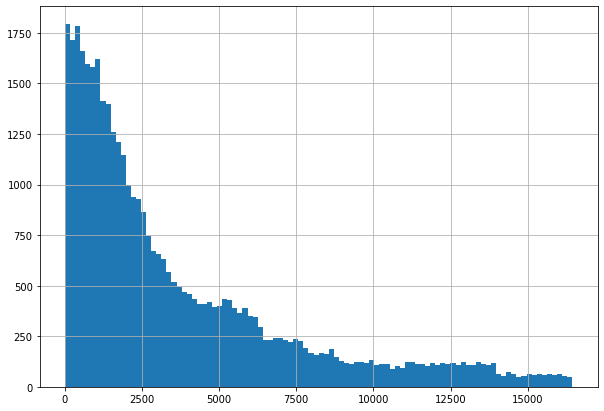

In [63]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)
df_train['Ranking'].describe()


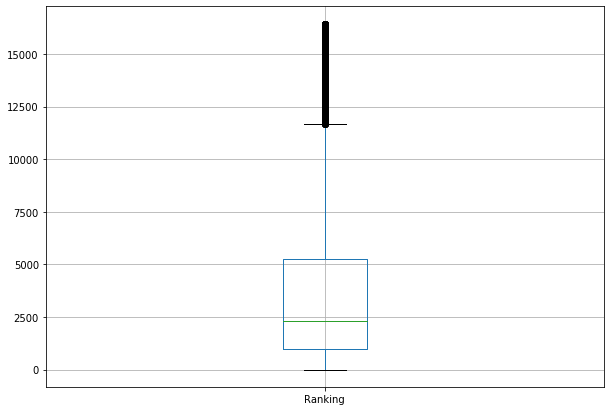

In [64]:
boxplot = df_train.boxplot(column = ['Ranking'])

Проверим значения Rankings на выбросы.

In [65]:
# median = df_train.Ranking.median()
# IQR = df_train.Ranking.quantile(0.75) - df_train.Ranking.quantile(0.25)
# perc25 = df_train.Ranking.quantile(0.25)
# perc75 = df_train.Ranking.quantile(0.75)
# print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
#       "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Согласно расчёту значения внутреннего рейтинга выше 11690 статистически являются выбросами.

Уберем рестораны, являющиеся "выбросами" из общего датасета

In [66]:
# df = df[df['ranking'] <= 11690]


Распределение по городам очевидно показывает преобладание в больших городах

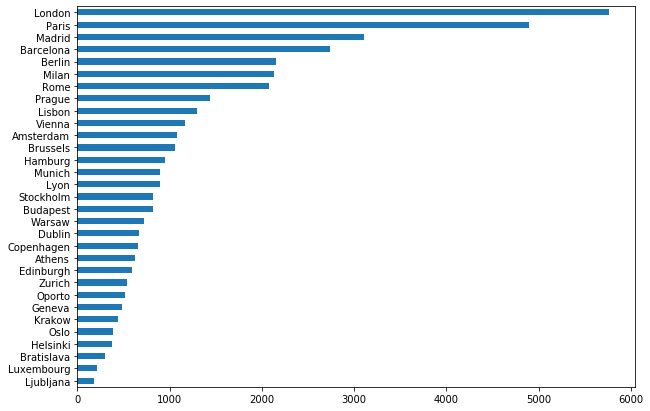

In [67]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Распределение внутренних рейтингов в Лондоне. 

Распределение рейтингов по городам. Очевидно, что города с большим населением имеют больше высоких оценок. Целесообразно для оценки использовать соотношение рейтинга к населению

In [68]:
data_vis.columns

Index(['id', 'city', 'cuisine', 'ranking', 'price', 'num_rew', 'reviews',
       'url', 'id_ta', 'mark', 'rating', 'City_ind', 'city_rest', 'std_rank',
       'population', 'country', 'country_ind', 'flow', 'cus_number',
       'American', 'Asian', 'Bar', 'British', 'Cafe', 'Chinese', 'European',
       'Fast Food', 'French', 'Indian', 'International', 'Italian', 'Japanese',
       'Mediterranean', 'No_info', 'Pizza', 'Pub', 'Seafood', 'Spanish',
       'Sushi', 'Thai', 'Vegetarian Friendly', 'last_rew', 'last_rew_date',
       'ratio_rev', 'net', 'count', 'flow_pop', 'std_flow'],
      dtype='object')

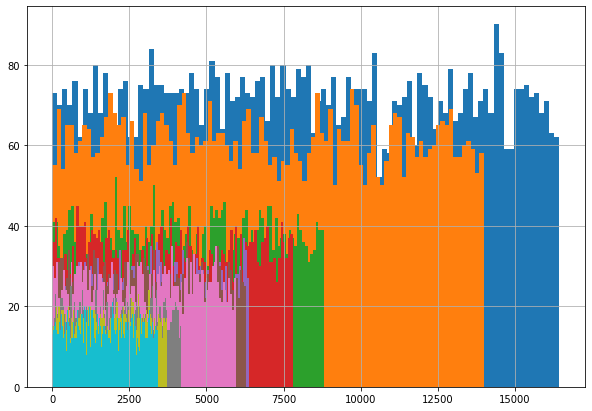

In [69]:
for x in (data_vis['city'].value_counts())[0:10].index:
    data_vis['ranking'][data_vis['city'] == x].hist(bins=100)
plt.show()

Распределение отзывов для рейтинга 5. 

Преобладающее большинство ресторанов с рейтингом 5 имеют относительно небольшое количество отзывов. Из всего тренеровочного сета таких ресторанов 3879

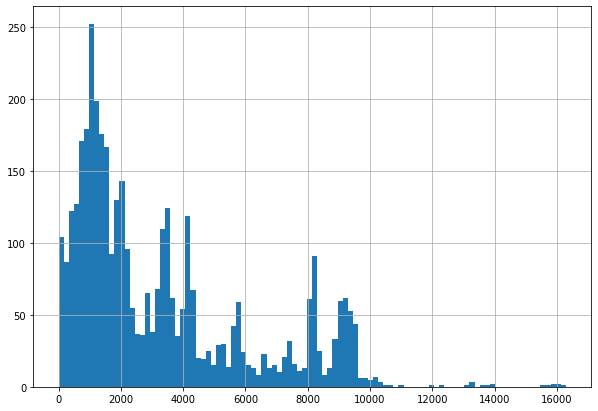

In [70]:
df['ranking'][df['rating'] == 5].hist(bins=100)

In [71]:
df_high = df_train[df_train['Rating'] == 5]
df_high.Rating.value_counts()

5.0    3879
Name: Rating, dtype: int64

Распределение отзывов для рейтинга ниже 4

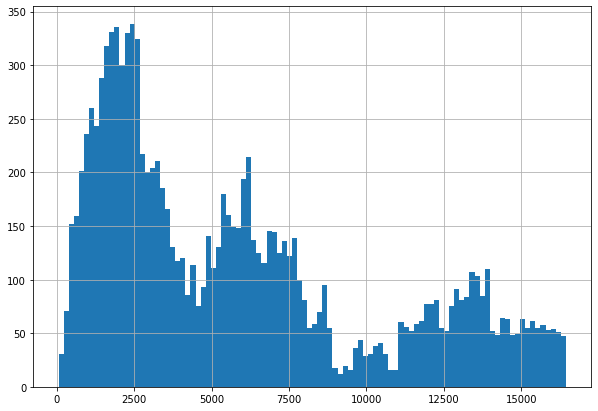

In [72]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [73]:
df.rating.isna().value_counts()

False    50000
Name: rating, dtype: int64

In [74]:
corr_matrix = df.corr(method = 'pearson')
# corr_matrix

In [75]:
corr_matrix.rating.sort_values(ascending = False)

rating                 1.000000
mark                   0.936543
net                    0.331677
count                  0.150831
Vegetarian Friendly    0.037317
cus_number             0.034506
Mediterranean          0.018614
European               0.015997
City_ind               0.013400
country_ind            0.013304
Cafe                   0.012097
num_rew                0.011626
International          0.011148
Italian                0.009372
French                 0.006533
Seafood                0.004679
ratio_rev              0.003576
Pub                    0.003238
Bar                    0.003131
British                0.002980
Thai                   0.002007
Fast Food             -0.001692
Pizza                 -0.001764
Spanish               -0.002147
Asian                 -0.004235
flow_pop              -0.004585
std_flow              -0.004585
Indian                -0.006542
last_rew_date         -0.007282
Sushi                 -0.007682
price                 -0.008182
populati

Согласно корреляционной матрице наибольшее влияние оказывает сетевой формат ресторана. Очевидно, что благодаря охвату. Сам по себе сетевой признак (1 или 0) оказывает меньшее влияние.

In [76]:
corr_matrix.rating.sort_values(ascending = False)[1:]

mark                   0.936543
net                    0.331677
count                  0.150831
Vegetarian Friendly    0.037317
cus_number             0.034506
Mediterranean          0.018614
European               0.015997
City_ind               0.013400
country_ind            0.013304
Cafe                   0.012097
num_rew                0.011626
International          0.011148
Italian                0.009372
French                 0.006533
Seafood                0.004679
ratio_rev              0.003576
Pub                    0.003238
Bar                    0.003131
British                0.002980
Thai                   0.002007
Fast Food             -0.001692
Pizza                 -0.001764
Spanish               -0.002147
Asian                 -0.004235
flow_pop              -0.004585
std_flow              -0.004585
Indian                -0.006542
last_rew_date         -0.007282
Sushi                 -0.007682
price                 -0.008182
population            -0.009514
American

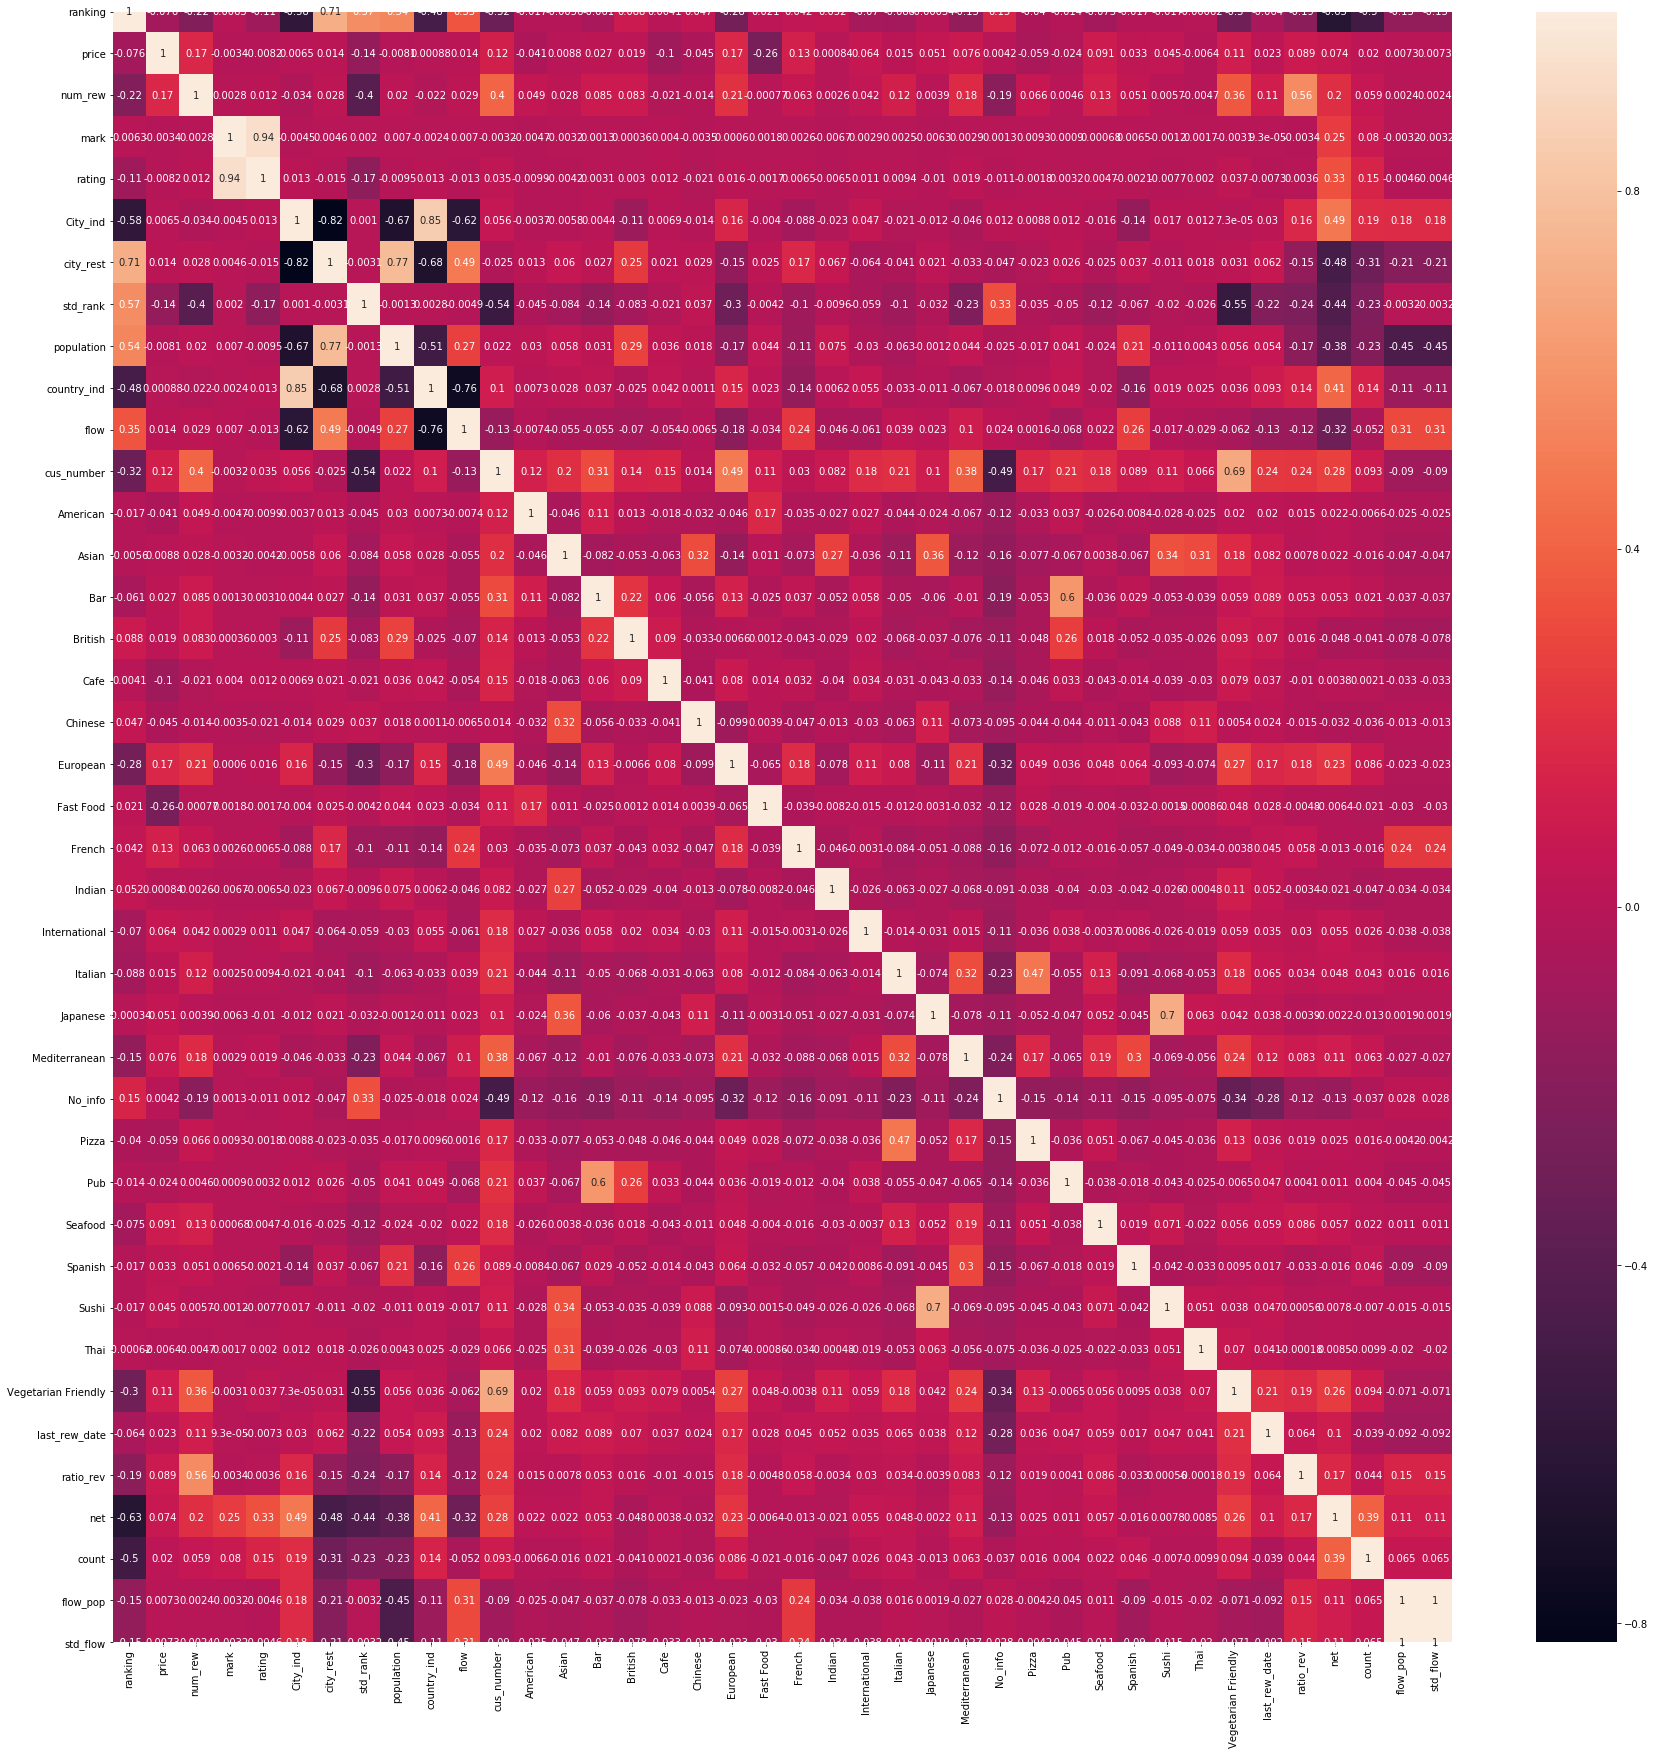

In [77]:
plt.figure(figsize=(30,30)) # размер графика
sns.heatmap(data = corr_matrix, annot=True)

In [78]:
train_data = df.query('mark == 1').drop(['mark'], axis=1)
test_data = df.query('mark == 0').drop(['mark'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [80]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [81]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [82]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.201075625


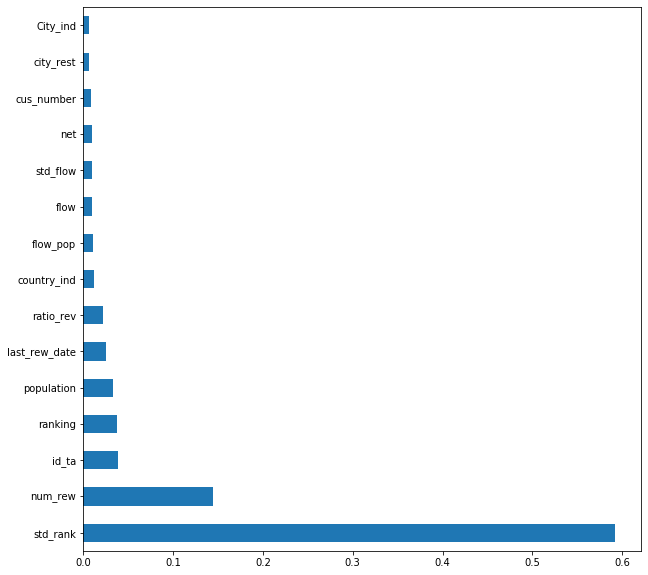

In [83]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Ниже указанны шаги, предпринятые для оптимизации модели. Изменения вносились в код выше.

1. Первое приближение (MAE: 0.208358125)

1.1 Согласно оценке в первом приближении наименьшее влияние на прогноз оказали кухни. Вполне ожидаемо город расположения имеет сильное влияние. Попробуем заменить идентификатор города на соотношение отзывов и населения

1.2 Признак Ranking очевидно сильно влияет, так как выступает в роли привлекательности ресторана.

2. Второе приближение. (MAE: 0.20872625) 

2.1 Добавим признак сетевых ресторанов. 

3. Третье приближение MAE: (0.20782499)

3.1 Попробуем убрать незначительные признаки (убираем идентификаторы кухонь), оставив только более или менее выраженные

4. Четвертое приближение (MAE: 0.203624375)

4.1 Добавим нормализацию признака "рейтинг"

5. Пятое приближение (MAE: 0.20099937 )

Со всеми числовыми признаками

# Submission


In [84]:
# test_data.sample(10)
# test_data = test_data.drop(['rating'], axis=1)

In [85]:
# len(test_data)

In [86]:
# len(sample_submission)

In [87]:
# predict_submission = regr.predict(test_data)

# len(predict_submission)

In [88]:
# def round_nearest(x, a):
#     return round(x / a) * a

# sample_submission['Rating'] = predict_submission.round(1)
# sample_submission['Rating'] = round_nearest(sample_submission['Rating'], 0.5)


# sample_submission.head(10)

# sample_submission.to_csv('submission.csv', index=False)

In [89]:
# data = pd.read_csv('submission.csv')
# data.head()